In [1]:
import numpy as np
import matplotlib.pyplot as plt
import PySimpleGUI as sg
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from scipy.signal import chirp, spectrogram
import scipy.fft as fft

In [2]:
plt.style.use('Solarize_Light2')

# Helper Functions


def draw_figure(canvas, figure):
    figure_canvas_agg = FigureCanvasTkAgg(figure, canvas)
    figure_canvas_agg.draw()
    figure_canvas_agg.get_tk_widget().pack(side='top', fill='both', expand=1)
    return figure_canvas_agg

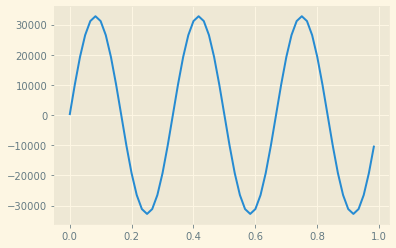

In [6]:
#https://towardsdatascience.com/integrating-pyplot-and-pysimplegui-b68be606b960

# Produce a sine wave with a slider that determines its sampling rate

import PySimpleGUI as sg
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

# VARS CONSTS:
# Upgraded dataSize to global...
_VARS = {'window': False,
         'fig_agg': False,
         'pltFig': False,
         'sampling_rate': 60,
         'max_frequency': 800,
         'frequency': 800,
         'peak_amplitude': 1,
         'pulse_time': 1,
         'pulse_type': 'Constant'}

pulse_choices = ('Constant', 'Chirp')

plt.style.use('Solarize_Light2')

# Helper Functions


def draw_figure(canvas, figure):
    figure_canvas_agg = FigureCanvasTkAgg(figure, canvas)
    figure_canvas_agg.draw()
    figure_canvas_agg.get_tk_widget().pack(side='top', fill='both', expand=1)
    return figure_canvas_agg


# \\  -------- PYSIMPLEGUI -------- //

AppFont = 'Any 16'
SliderFont = 'Any 14'
sg.theme('black')



# New layout with slider and padding

options = [[sg.Text(text = "Max frequency (Chirp)", background_color='#FDF6E3', text_color='Black')],
           [sg.InputText(_VARS['max_frequency'], key = '-max_frequency-')],
           [sg.Text(text = "Frequency (Constant)", background_color='#FDF6E3', text_color='Black')],
           [sg.InputText(_VARS['frequency'], key = '-frequency-')],
           [sg.Text(text = "Peak amplitude", background_color='#FDF6E3', text_color='Black')],
           [sg.InputText(_VARS['peak_amplitude'], key = '-peak_amplitude-')],
           [sg.Text(text = "Sampling rate", background_color='#FDF6E3', text_color='Black')],
           [sg.InputText(_VARS['sampling_rate'], key = '-sampling_rate-')],
           [sg.Text(text = "Pulse time", background_color='#FDF6E3', text_color='Black')],
           [sg.InputText(_VARS['pulse_time'], key = '-pulse_time-')],
           [sg.Text(text = "Pulse type", background_color='#FDF6E3', text_color='Black')],
           [sg.Listbox(pulse_choices, default_values = 'Constant', select_mode='extended', key = '-pulse_type-', size=(30, 6))],
           [sg.Button('OK', font=AppFont, pad=((4, 0), (10, 0)))]]
           #[sg.InputText(_VARS['pulse_type'])]]

layout = [ [sg.Canvas(key='figCanvas', background_color='#FDF6E3')],
          #[sg.Canvas(key='figCanvasFreq', background_color='#FDF6E3')],  
          [sg.Text(text="Random sample size :",
                   font=SliderFont,
                   background_color='#FDF6E3',
                   pad=((0, 0), (10, 0)),
                   text_color='Black'),
           sg.Slider(range=(4, 1000), orientation='h', size=(34, 20),
                     default_value=_VARS['sampling_rate'],
                     background_color='#FDF6E3',
                     text_color='Black',
                     key='-Slider-',
                     enable_events=True),
           sg.Button('Resample',
                     font=AppFont,
                     pad=((4, 0), (10, 0)))],
          # pad ((left, right), (top, bottom))
          [sg.Button('Exit', font=AppFont, pad=((540, 0), (0, 0)))] ]


master_layout = [[sg.Column(options, background_color='#FDF6E3'), 
                  sg.Column(layout, background_color='#FDF6E3')]]
         

_VARS['window'] = sg.Window('Random Samples',
                            master_layout,
                            finalize=True,
                            resizable=True,
                            location=(100, 100),
                            element_justification="center",
                            background_color='#FDF6E3')

# \\  -------- PYSIMPLEGUI -------- //


# \\  -------- PYPLOT -------- //


def makeSynthData():
    if _VARS['pulse_type'] == 'Constant':      
        sampling_interval = 1/_VARS['sampling_rate']

        freq = 3
        omega = 2*np.pi*freq
        amplitude = np.iinfo(np.int16).max # output machine limit for type

        xData = np.arange(0, _VARS['pulse_time'], sampling_interval)
        yData = _VARS['peak_amplitude']*amplitude*np.sin(omega*xData)
        
        

    if _VARS['pulse_type'] == 'Chirp':
        sampling_interval = 1/_VARS['sampling_rate']
        
        amplitude = np.iinfo(np.int16).max # output machine limit for type
        
        xData = np.arange(0, _VARS['pulse_time'], sampling_interval) # 4-second chirp    
        yData = _VARS['peak_amplitude']*amplitude*chirp(xData, f0=100, f1=_VARS['max_frequency'], \
                    t1=_VARS['pulse_time'], method='linear') #  f0 = initial freq, f1 = freq at t1
        
    FFT = fft.rfft(yData)
    psdData = 10*np.log(np.abs(FFT)**2) # Power spectral density
    freqData = fft.rfftfreq(xData.size, 1/_VARS['sampling_rate']) # (window length, sample spacing)
        
    return (xData, yData, psdData, freqData)


def drawChart():
    _VARS['pltFig'] = plt.figure()
    dataXY = makeSynthData()
    plt.plot(dataXY[0], dataXY[1]) #, '.k')
    _VARS['fig_agg'] = draw_figure(
        _VARS['window']['figCanvas'].TKCanvas, _VARS['pltFig'])
    idx = np.argsort(dataXY[3])
    freqs = dataXY[2]
    PSD = dataXY[3]
    #plt.plot(freqs[idx], PSD[idx]) #, '.k')
    #_VARS['fig_agg'] = draw_figure(
    #    _VARS['window']['figCanvas'].TKCanvas, _VARS['pltFig'])
       


def updateChart():
    _VARS['fig_agg'].get_tk_widget().forget()
    dataXY = makeSynthData()
    # plt.cla()
    plt.clf()
    plt.plot(dataXY[0], dataXY[1]) #, '.k')
    _VARS['fig_agg'] = draw_figure(
        _VARS['window']['figCanvas'].TKCanvas, _VARS['pltFig'])
    idx = np.argsort(dataXY[3])
    freqs = dataXY[2]
    PSD = dataXY[3]
    #plt.plot(freqs[idx], PSD[idx]) #, '.k')
    #_VARS['fig_agg'] = draw_figure(
    #    _VARS['window']['figCanvas'].TKCanvas, _VARS['pltFig'])

def updateData(val):
    _VARS['sampling_rate'] = val
    updateChart()
    
def updateParameters(max_freq, freq, peak_amp, s_rate, p_time, p_type):

    _VARS['max_frequency'] = max_freq
    _VARS['frequency'] = freq
    _VARS['peak_amplitude'] = peak_amp
    _VARS['sampling_rate'] = s_rate
    _VARS['pulse_time'] = p_time
    p_type = p_type.replace("['" ,"")
    p_type = p_type.replace("']" ,"")
    if p_type == " ":
        _VARS['pulse_type'] = _VARS['pulse_type']
    else:
        _VARS['pulse_type'] = p_type  
    updateChart()

# \\  -------- PYPLOT -------- //


drawChart()

# MAIN LOOP
while True:
    event, values = _VARS['window'].read(timeout=200)
    if event == sg.WIN_CLOSED or event == 'Exit':
        break
    elif event == 'Resample':
        updateChart()
    elif event == '-Slider-':
        updateData(int(values['-Slider-']))
    elif event == 'OK':
        updateParameters(float(values['-max_frequency-']),float(values['-frequency-']), \
                         float(values['-peak_amplitude-']),float(values['-sampling_rate-']), \
                         float(values['-pulse_time-']), str(values['-pulse_type-']))

        
        # print(int(values['-Slider-']))
_VARS['window'].close()


In [5]:
import PySimpleGUI as psg
#set the theme for the screen/window
psg.theme('SandyBeach')
#define layout
layout=[[psg.Text('Choose Boarding place',size=(20, 1), font='Lucida',justification='left')],
        [psg.Combo(['New York','Chicago','Washington', 'Colorado','Ohio','San Jose','Fresno','San Fransisco'],default_value='Utah',key='board')],
        [psg.Text('Choose Destination ',size=(30, 1), font='Lucida',justification='left')],
        [psg.Combo(['New York','Chicago','Washington', 'Colorado','Ohio','San Jose','Fresno','San Fransisco'],key='dest')],
        [psg.Text('Choose additional Facilities',size=(30, 1), font='Lucida',justification='left')],
        [psg.Listbox(values=['Welcome Drink', 'Extra Cushions', 'Organic Diet','Blanket', 'Neck Rest'], select_mode='extended', key='fac', size=(30, 6))],
        [psg.Button('SAVE', font=('Times New Roman',12)),psg.Button('CANCEL', font=('Times New Roman',12))]]
#Define Window
win =psg.Window('Customise your Journey',layout)
#Read  values entered by user
e,v=win.read()
#close first window
win.close()
#access the selected value in the list box and add them to a string
strx=""
for val in v['fac']:
    strx=strx+ " "+ val+","
        
#display string in a popup         
psg.popup('Options Chosen',      
            'You will Travel from :'+ v['board'] + ' to '+v['dest'] +' \nYour additional facilities are:' +strx[1:len(strx)-1] )



'OK'

In [12]:
# Produce a sine wave
def func(sampling_rate):

    sampling_interval = 1/sampling_rate

    freq = 3
    omega = 2*np.pi*freq
    amplitude = np.iinfo(np.int16).max # output machine limit for type

    t = np.arange(0, 4, sampling_interval)
    y = amplitude*np.sin(omega*t)
    fig1 = plt.plot(t, y)

layout = [  [sg.Text('Sampling Rate (kHz)'), sg.InputText()],
            [sg.Button('Ok'), sg.Exit('Cancel')] ]

window = sg.Window('Sine wave', layout, finalize=True, element_justification='center', font='Monospace 18')
 


while True:             # Event Loop
    event, values = window.Read()
    print(values)
    #print(type(values[0]))
    func(float(values[0])) # only displays the graph when I exit the GUI
    if event == sg.WIN_CLOSED or event == 'Exit':
        break

window.Close()

{0: ''}


ValueError: could not convert string to float: ''

Add {'-CANVAS-': None}
Add {'-CANVAS-': None}
Add {'-CANVAS-': None}
Add {'-CANVAS-': None}
Add {'-CANVAS-': None}
Add {'-CANVAS-': None}
Add {'-CANVAS-': None}
Add {'-CANVAS-': None}
Add {'-CANVAS-': None}
None None


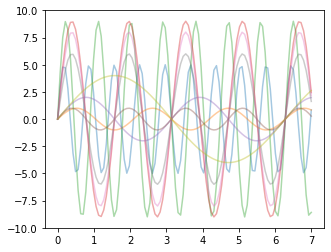

In [11]:
import numpy as np
import PySimpleGUI as sg
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

#Functions to prevent GUI blurring
#def make_dpi_aware():
#  import ctypes
#  import platform
  #if int(platform.release()) >= 8:
#  ctypes.windll.shcore.SetProcessDpiAwareness(True)
#make_dpi_aware()

#Function for drawing
def draw_figure(canvas, figure):
    figure_canvas_agg = FigureCanvasTkAgg(figure, canvas)
    figure_canvas_agg.draw()
    figure_canvas_agg.get_tk_widget().pack(side='top', fill='both', expand=1)
    return figure_canvas_agg

#Layout creation
layout = [[sg.Text('Embed Matplotlib Plot')],
          [sg.Canvas(key='-CANVAS-')],
          [sg.Button("Add"), sg.Button("Clear")]]

#Create a window. finalize=Must be True.
window = sg.Window('Demo Application - Embedding Matplotlib In PySimpleGUI', layout, finalize=True, element_justification='center', font='Monospace 18')

#Create a fig for embedding.
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(111)
ax.set_ylim(-10, 10)

#Associate fig with Canvas.
fig_agg = draw_figure(window['-CANVAS-'].TKCanvas, fig)

#Event loop
while True:
    event, values = window.read()
    print(event, values)
    # sg.Print(event, values)
    
    if event in (None, "Cancel"):
        break
    
    elif event == "Add":
        #Creating appropriate plot data
        t = np.linspace(0, 7, 100)
        afreq = np.random.randint(1, 10)
        amp = np.random.randint(1, 10)
        y = amp * np.sin(afreq * t)
        
        #plot
        ax.plot(t, y, alpha=0.4)
        
        #After making changes, fig_agg.draw()Reflect the change with.
        fig_agg.draw()

    elif event == "Clear":
        ax.cla()
        fig_agg.draw()

#close the window.
window.close()


In [8]:
import platform
print(platform.release())

17.7.0


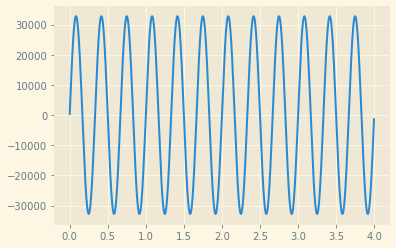

In [64]:
#https://towardsdatascience.com/integrating-pyplot-and-pysimplegui-b68be606b960

# Produce a sine wave with a slider that determines its sampling rate

import PySimpleGUI as sg
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

# VARS CONSTS:
# Upgraded dataSize to global...
_VARS = {'window': False,
         'fig_agg': False,
         'pltFig': False,
         'sampling_rate': 60}


plt.style.use('Solarize_Light2')

# Helper Functions


def draw_figure(canvas, figure):
    figure_canvas_agg = FigureCanvasTkAgg(figure, canvas)
    figure_canvas_agg.draw()
    figure_canvas_agg.get_tk_widget().pack(side='top', fill='both', expand=1)
    return figure_canvas_agg


# \\  -------- PYSIMPLEGUI -------- //

AppFont = 'Any 16'
SliderFont = 'Any 14'
sg.theme('black')

# New layout with slider and padding

layout = [[sg.Canvas(key='figCanvas', background_color='#FDF6E3')],
          [sg.Text(text="Random sample size :",
                   font=SliderFont,
                   background_color='#FDF6E3',
                   pad=((0, 0), (10, 0)),
                   text_color='Black'),
           sg.Slider(range=(4, 1000), orientation='h', size=(34, 20),
                     default_value=_VARS['sampling_rate'],
                     background_color='#FDF6E3',
                     text_color='Black',
                     key='-Slider-',
                     enable_events=True),
           sg.Button('Resample',
                     font=AppFont,
                     pad=((4, 0), (10, 0)))],
          # pad ((left, right), (top, bottom))
          [sg.Button('Exit', font=AppFont, pad=((540, 0), (0, 0)))]]

_VARS['window'] = sg.Window('Random Samples',
                            layout,
                            finalize=True,
                            resizable=True,
                            location=(100, 100),
                            element_justification="center",
                            background_color='#FDF6E3')

# \\  -------- PYSIMPLEGUI -------- //


# \\  -------- PYPLOT -------- //


def makeSynthData():
    sampling_interval = 1/_VARS['sampling_rate']

    freq = 3
    omega = 2*np.pi*freq
    amplitude = np.iinfo(np.int16).max # output machine limit for type

    xData = np.arange(0, 4, sampling_interval)
    yData = amplitude*np.sin(omega*xData)
    #xData = np.random.randint(100, size=_VARS['dataSize'])
    #yData = np.linspace(0, _VARS['dataSize'],
                       # num=_VARS['dataSize'], dtype=int)
    return (xData, yData)


def drawChart():
    _VARS['pltFig'] = plt.figure()
    dataXY = makeSynthData()
    plt.plot(dataXY[0], dataXY[1]) #, '.k')
    _VARS['fig_agg'] = draw_figure(
        _VARS['window']['figCanvas'].TKCanvas, _VARS['pltFig'])


def updateChart():
    _VARS['fig_agg'].get_tk_widget().forget()
    dataXY = makeSynthData()
    # plt.cla()
    plt.clf()
    plt.plot(dataXY[0], dataXY[1]) #, '.k')
    _VARS['fig_agg'] = draw_figure(
        _VARS['window']['figCanvas'].TKCanvas, _VARS['pltFig'])


def updateData(val):
    _VARS['sampling_rate'] = val
    updateChart()

# \\  -------- PYPLOT -------- //


drawChart()

# MAIN LOOP
while True:
    event, values = _VARS['window'].read(timeout=200)
    if event == sg.WIN_CLOSED or event == 'Exit':
        break
    elif event == 'Resample':
        updateChart()
    elif event == '-Slider-':
        updateData(int(values['-Slider-']))
        # print(values)
        # print(int(values['-Slider-']))
_VARS['window'].close()


In [44]:
#columns example
import PySimpleGUI as sg
#set the theme for the screen/window
sg.theme("DarkTanBlue")
#define layout
sz=(10,20)
col1=[[sg.Text('Column1', background_color='grey', size=sz)]]
col2=[[sg.Text('Column2', background_color='grey', size=(50,20))]]


layout = [[sg.Column(col1, element_justification='c' ), sg.Column(col2, element_justification='c')]]

window =sg.Window("Column and Frame",layout)
event,values=window.read()

window.close() 

In [28]:
import PySimpleGUI as sg

sg.theme('Dark Blue 3')  # please make your windows colorful

layout = [
            [sg.Text('Please enter your Name, Address, Phone')],
            [sg.Text('Name', size=(15, 1)), sg.InputText('1', key='-NAME-')],
            [sg.Text('Address', size=(15, 1)), sg.InputText('2', key='-ADDRESS-')],
            [sg.Text('Phone', size=(15, 1)), sg.InputText('3', key='-PHONE-')],
            [sg.Submit(), sg.Cancel()]
            ]

window = sg.Window('Simple data entry window', layout)
event, values = window.read()
window.close()

sg.Popup(event, values, values['-NAME-'], values['-ADDRESS-'], values['-PHONE-'])

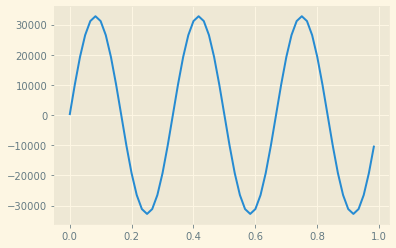

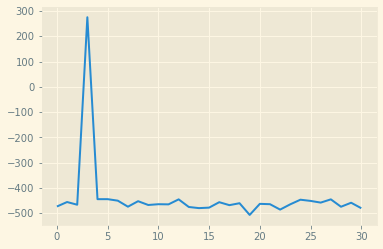

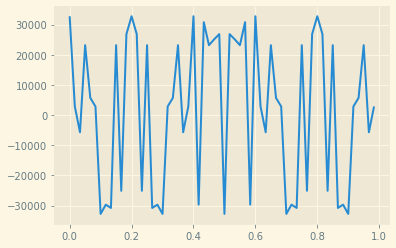

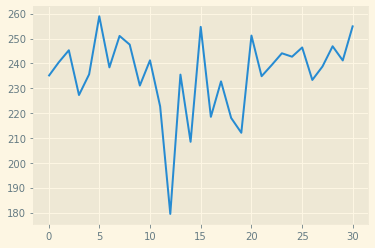

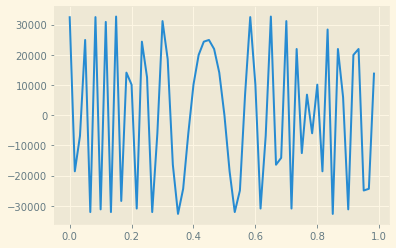

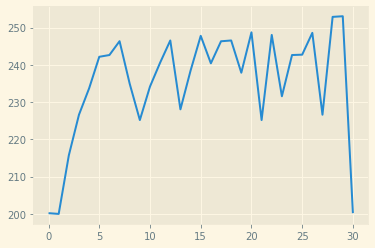

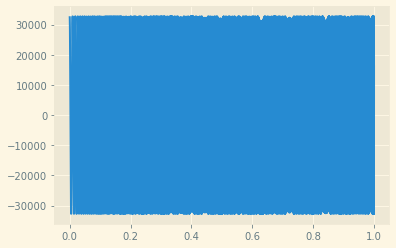

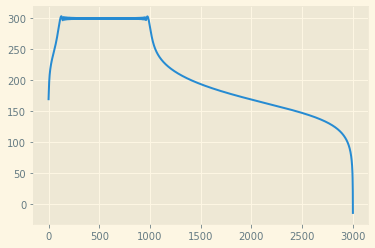

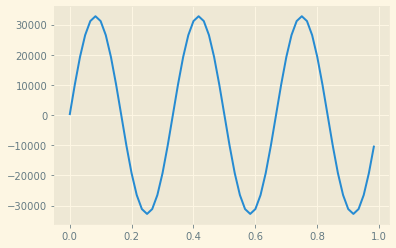

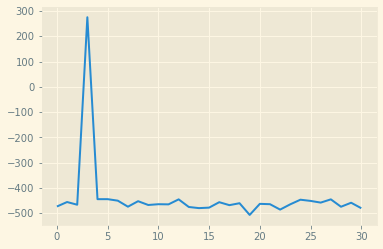

In [4]:
#https://towardsdatascience.com/integrating-pyplot-and-pysimplegui-b68be606b960

# Produce a sine wave with a slider that determines its sampling rate

import PySimpleGUI as sg
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

# VARS CONSTS:
# Upgraded dataSize to global...
_VARS = {'window': False,
         'fig_agg1': False,
         'fig_agg2': False,
         'pltFig1': False,
         'pltFig2': False,
         'sampling_rate': 60,
         'max_frequency': 800,
         'frequency': 800,
         'peak_amplitude': 1,
         'pulse_time': 1,
         'pulse_type': 'Constant'}

pulse_choices = ('Constant', 'Chirp')

plt.style.use('Solarize_Light2')

# Helper Functions


def draw_figure(canvas, figure):
    figure_canvas_agg = FigureCanvasTkAgg(figure, canvas)
    figure_canvas_agg.draw()
    figure_canvas_agg.get_tk_widget().pack(side='top', fill='both', expand=1)
    return figure_canvas_agg


# \\  -------- PYSIMPLEGUI -------- //

AppFont = 'Any 16'
SliderFont = 'Any 14'
sg.theme('black')



# New layout with slider and padding

options = [[sg.Text(text = "Max frequency (Chirp)", background_color='#FDF6E3', text_color='Black')],
           [sg.InputText(_VARS['max_frequency'], key = '-max_frequency-')],
           [sg.Text(text = "Frequency (Constant)", background_color='#FDF6E3', text_color='Black')],
           [sg.InputText(_VARS['frequency'], key = '-frequency-')],
           [sg.Text(text = "Peak amplitude", background_color='#FDF6E3', text_color='Black')],
           [sg.InputText(_VARS['peak_amplitude'], key = '-peak_amplitude-')],
           [sg.Text(text = "Sampling rate", background_color='#FDF6E3', text_color='Black')],
           [sg.InputText(_VARS['sampling_rate'], key = '-sampling_rate-')],
           [sg.Text(text = "Pulse time", background_color='#FDF6E3', text_color='Black')],
           [sg.InputText(_VARS['pulse_time'], key = '-pulse_time-')],
           [sg.Text(text = "Pulse type", background_color='#FDF6E3', text_color='Black')],
           [sg.Listbox(pulse_choices, default_values = 'Constant', select_mode='extended', key = '-pulse_type-', size=(30, 6))],
           [sg.Button('OK', font=AppFont, pad=((4, 0), (10, 0)))]]
           #[sg.InputText(_VARS['pulse_type'])]]

layout = [ [sg.Canvas(key='figCanvas', background_color='#FDF6E3')],
          [sg.Canvas(key='figCanvasFreq', background_color='#FDF6E3')],  
          [sg.Text(text="Random sample size :",
                   font=SliderFont,
                   background_color='#FDF6E3',
                   pad=((0, 0), (10, 0)),
                   text_color='Black'),
           sg.Slider(range=(4, 1000), orientation='h', size=(34, 20),
                     default_value=_VARS['sampling_rate'],
                     background_color='#FDF6E3',
                     text_color='Black',
                     key='-Slider-',
                     enable_events=True),
           sg.Button('Resample',
                     font=AppFont,
                     pad=((4, 0), (10, 0)))],
          # pad ((left, right), (top, bottom))
          [sg.Button('Exit', font=AppFont, pad=((540, 0), (0, 0)))] ]


master_layout = [[sg.Column(options, background_color='#FDF6E3'), 
                  sg.Column(layout, background_color='#FDF6E3')]]
         

_VARS['window'] = sg.Window('Random Samples',
                            master_layout,
                            finalize=True,
                            resizable=True,
                            location=(100, 100),
                            element_justification="center",
                            background_color='#FDF6E3')

# \\  -------- PYSIMPLEGUI -------- //


# \\  -------- PYPLOT -------- //


def makeSynthData():
    if _VARS['pulse_type'] == 'Constant':      
        sampling_interval = 1/_VARS['sampling_rate']

        freq = 3
        omega = 2*np.pi*freq
        amplitude = np.iinfo(np.int16).max # output machine limit for type

        xData = np.arange(0, _VARS['pulse_time'], sampling_interval)
        yData = _VARS['peak_amplitude']*amplitude*np.sin(omega*xData)
        
        

    if _VARS['pulse_type'] == 'Chirp':
        sampling_interval = 1/_VARS['sampling_rate']
        
        amplitude = np.iinfo(np.int16).max # output machine limit for type
        
        xData = np.arange(0, _VARS['pulse_time'], sampling_interval) # 4-second chirp    
        yData = _VARS['peak_amplitude']*amplitude*chirp(xData, f0=100, f1=_VARS['max_frequency'], \
                    t1=_VARS['pulse_time'], method='linear') #  f0 = initial freq, f1 = freq at t1
        
    FFT = fft.rfft(yData)
    psdData = 10*np.log(np.abs(FFT)**2) # Power spectral density
    freqData = fft.rfftfreq(xData.size, 1/_VARS['sampling_rate']) # (window length, sample spacing)
        
    return (xData, yData , freqData, psdData)


def drawChart():
    _VARS['pltFig1'] = plt.figure()
    dataXY = makeSynthData()
    plt.plot(dataXY[0], dataXY[1]) #, '.k')
    _VARS['fig_agg1'] = draw_figure(
        _VARS['window']['figCanvas'].TKCanvas, _VARS['pltFig1'])
    
    _VARS['pltFig2'] = plt.figure()
    idx = np.argsort(dataXY[2])
    freqs = dataXY[2]
    PSD = dataXY[3]

    plt.plot(freqs[idx], PSD[idx]) #, '.k')
    _VARS['fig_agg2'] = draw_figure(
        _VARS['window']['figCanvasFreq'].TKCanvas, _VARS['pltFig2'])
       


def updateChart():
    _VARS['pltFig1'] = plt.figure()
    _VARS['fig_agg1'].get_tk_widget().forget()
    
    dataXY = makeSynthData()
    # plt.cla()
    plt.clf()
    plt.plot(dataXY[0], dataXY[1]) #, '.k')
    _VARS['fig_agg1'] = draw_figure(
        _VARS['window']['figCanvas'].TKCanvas, _VARS['pltFig1'])
    
    _VARS['pltFig2'] = plt.figure()
    _VARS['fig_agg2'].get_tk_widget().forget()    
    plt.clf()
    idx = np.argsort(dataXY[2])
    freqs = dataXY[2]
    PSD = dataXY[3]
    plt.plot(freqs[idx], PSD[idx]) #, '.k')
    _VARS['fig_agg2'] = draw_figure(
        _VARS['window']['figCanvasFreq'].TKCanvas, _VARS['pltFig2'])

def updateData(val):
    _VARS['sampling_rate'] = val
    updateChart()
    
def updateParameters(max_freq, freq, peak_amp, s_rate, p_time, p_type):

    _VARS['max_frequency'] = max_freq
    _VARS['frequency'] = freq
    _VARS['peak_amplitude'] = peak_amp
    _VARS['sampling_rate'] = s_rate
    _VARS['pulse_time'] = p_time
    p_type = p_type.replace("['" ,"")
    p_type = p_type.replace("']" ,"")
    if p_type == " ":
        _VARS['pulse_type'] = _VARS['pulse_type']
    else:
        _VARS['pulse_type'] = p_type  
    updateChart()

# \\  -------- PYPLOT -------- //


drawChart()

# MAIN LOOP
while True:
    event, values = _VARS['window'].read(timeout=200)
    if event == sg.WIN_CLOSED or event == 'Exit':
        break
    elif event == 'Resample':
        updateChart()
    elif event == '-Slider-':
        updateData(int(values['-Slider-']))
    elif event == 'OK':
        updateParameters(float(values['-max_frequency-']),float(values['-frequency-']), \
                         float(values['-peak_amplitude-']),float(values['-sampling_rate-']), \
                         float(values['-pulse_time-']), str(values['-pulse_type-']))

        
        # print(int(values['-Slider-']))
_VARS['window'].close()
